Code to build and save various hidden weight initializations.

In [13]:
import sys

sys.path.append("..")
import BuildHiddenWeights as bhw  # builders
import HiddenWeightHelpers as hw  # plots, stats, norms, saving, open-loop
from RNN_Class import *
import math, torch, torch.nn as nn
import matplotlib.pyplot as plt

In [14]:
SAVE_DIR = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/clean"
N = 100
NOISE_STD = 1e-2  # try 5e-3 to 1e-2
SEED = 42
HIDDEN_N = 100
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)

# Baseline

In [15]:
# prepare input -- asymmetric Gaussian
loaded = torch.load("../data/Ns100_SeqN100/encodings/Ns100_SeqN100_asym1.pth.tar")
pred = 1
X = loaded["X_mini"]
Y = loaded["Target_mini"]
X = X[:, :-pred]
Y = Y[:, pred:]

# build model (sigmoid head, W_xh identity) -- used for baseline
model = ElmanRNN_pytorch_module_v2(HIDDEN_N, HIDDEN_N, HIDDEN_N)
model.act = nn.Sigmoid()

In [16]:
# --- Baseline (random) ---
# Baseline random initialization
W, W_xh, W_hy = hw.get_numpy_weights(model)
emp_var = float(W.var())
print(f"empirical var ≈ {emp_var:.6f}, theoretical var ≈ {THEO_VAR:.6f}")
print("INITIAL MATRICES")
# hw.plot_weight_all(W, title=f"Baseline Whh (H={HIDDEN_N})")
# hw.plot_weight_all(W_xh, title=f"Default Wxh (H={HIDDEN_N})")
# hw.plot_weight_all(W_hy, title=f"Default Why (H={HIDDEN_N})")

# 1) Symmetric / skew plots
print("INITIAL SYMMETRY")
# hw.plot_sym_asym(W, base_title="Random (raw)")

# verify circulant
ok = hw.is_circulant(W, tol=1e-7)
print("[builder] circulant? {} (tol=1e-7)".format(ok))

# 3) Save the baseline matrix
save_dir = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/clean/random/"

# hw.save_matrix(
#    W,
#    save_dir,
#    f"random_baseline",
#    meta={
#        "n": HIDDEN_N,
#    },
# )

empirical var ≈ 0.003322, theoretical var ≈ 0.003333
INITIAL MATRICES
INITIAL SYMMETRY
[builder] circulant? False (tol=1e-7)


# Identity

INITIAL MATRICES
INITIAL SYMMETRY
NORMALIZATION COMPARISON
[builder] circulant? True (tol=1e-7)


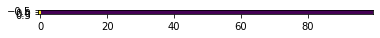

In [17]:
# --- identity matrix ---
W = bhw.build_shift(n=HIDDEN_N, value=1.0, offset=0, cyclic=False)

# quick plots
print("INITIAL MATRICES")
# hw.plot_weight_all(W, title=f"Identity Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
# hw.plot_sym_asym(W, base_title="Identity (raw)")

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
# hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# verify circulant
ok = hw.is_circulant(W_fro, tol=1e-7)
print("[builder] circulant? {} (tol=1e-7)".format(ok))
assert ok, "Expected a circulant matrix"

# save variants
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/clean/shift-variants/identity"
)
# hw.save_matrix(
#    W_fro,
#    f"{save_root}",
#    f"identity",
#    meta={
#        "norm": "fro",
#        "n": HIDDEN_N,
#    },
# )

# extract first row
row0 = hw.extract_first_row(W)

# hw.extract_and_optionally_save_first_row(
#    W,
#    save_dir="../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/#identity",
#    name="identity_row0",
# )

plt.imshow(row0.reshape(1, 100))
plt.show()

# Shift

In [18]:
def mix_ratio_tag(a: float) -> str:
    """0.90 -> 'sym0p90', 1.0 -> 'sym1p00'"""
    pct = int(round(a * 100))
    major = pct // 100
    minor = pct % 100
    return f"sym{major}p{minor:02d}"


def short_norm_tag(norm):
    return {
        "raw": "raw",
        "frobenius": "fro",
    }[norm]

## acyclic

In [7]:
# --- shift (acyclic) matrix ---
W = bhw.build_shift(n=HIDDEN_N, value=1.0, offset=1, cyclic=False)

# quick plots
print("INITIAL MATRICES")
# hw.plot_weight_all(W, title=f"Shift (acyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
# hw.plot_sym_asym(W, base_title="Shift (acyclic, raw)")

# symmetric / skew-symmetric split
S = 0.5 * (W + W.T)
A = 0.5 * (W - W.T)

# choose mixing ratios you want
mix_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# where to save this structure's init
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/clean/shift-variants/shift"
)

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

for alpha in mix_ratios:
    # alpha-blended hidden matrix: W_eff = αS + (1-α)A
    W_mix = alpha * S + (1 - alpha) * A

    # (optional) quick diagnostics
    print(f"λ = {alpha:.2f}")
    # hw.plot_sym_asym(W_mix, base_title=f"shift (acyclic) α={alpha:.2f}")
    # hw.plot_weight_all(W_mix, title=f"Whh (α={alpha:.2f}, raw)")
    # hw.plot_weight_all(W_mix, title=f"Shift (acyclic) Whh (H={HIDDEN_N})")

    # apply your three normalizations per alpha (and keep a raw copy)
    W_fro, _ = hw.normalize_by_fro(W_mix, target_fro=target_fro)

    # save under norm subfolders, with a alpha subdir (easy to browse)
    meta_base = {
        "structure": "shift (acyclic)",
        "hidden_n": int(HIDDEN_N),
        "lambda": float(alpha),
        "decomposition": "W=αS+(1-α)A",
        "notes": "normalized after α-mix",
    }
    sub = mix_ratio_tag(alpha)

    # verify circulant
    ok = hw.is_circulant(W_fro, tol=1e-7)
    print("[builder] circulant? {} (tol=1e-7)".format(ok))
    # assert ok, "Expected a circulant matrix"

    # frobenius
    # hw.save_matrix(
    #    W_fro,
    #    f"{save_root}/{sub}",
    #    f"shift_{sub}",
    #    meta={**meta_base, "norm": "frobenius", "target_fro": float(target_fro)},
    # )

INITIAL MATRICES
INITIAL SYMMETRY
λ = 0.00
[builder] circulant? False (tol=1e-7)
λ = 0.25
[builder] circulant? False (tol=1e-7)
λ = 0.50
[builder] circulant? False (tol=1e-7)
λ = 0.75
[builder] circulant? False (tol=1e-7)
λ = 1.00
[builder] circulant? False (tol=1e-7)


## cyclic

INITIAL MATRICES
INITIAL SYMMETRY
λ = 0.00
[builder] circulant? True (tol=1e-7)


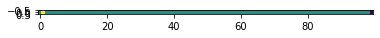

[ 0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.5]
λ = 0.25
[builder] circulant? True (tol=1e-7)


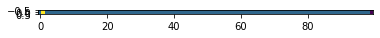

[ 0.    0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.   -0.25]
λ = 0.50
[builder] circulant? True (tol=1e-7)


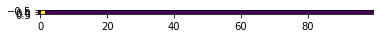

[0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
λ = 0.75
[builder] circulant? True (tol=1e-7)


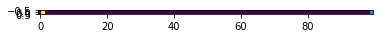

[0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.25]
λ = 1.00
[builder] circulant? True (tol=1e-7)


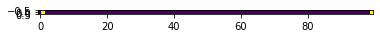

[0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]


In [8]:
# --- shift (cyclic) matrix ---
W = bhw.build_shift(n=HIDDEN_N, value=1.0, offset=1, cyclic=True)

# quick plots
print("INITIAL MATRICES")
# hw.plot_weight_all(W, title=f"Shift (cyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
# hw.plot_sym_asym(W, base_title="Shift (cyclic, raw)")

# symmetric / skew-symmetric split
S = 0.5 * (W + W.T)
A = 0.5 * (W - W.T)

# choose mixing ratios you want
mix_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# where to save this structure's init
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/clean/shift-variants/cyc-shift"
)

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

for alpha in mix_ratios:
    # alpha-blended hidden matrix: W_eff = αS + (1-α)A
    W_mix = alpha * S + (1 - alpha) * A

    # (optional) quick diagnostics
    print(f"λ = {alpha:.2f}")
    # hw.plot_sym_asym(W_mix, base_title=f"shift (cyclic) α={alpha:.2f}")
    # hw.plot_weight_all(W_mix, title=f"Whh (α={alpha:.2f}, raw)")

    # apply your three normalizations per alpha (and keep a raw copy)
    W_fro, _ = hw.normalize_by_fro(W_mix, target_fro=target_fro)

    # verify circulant
    ok = hw.is_circulant(W_fro, tol=1e-7)
    print("[builder] circulant? {} (tol=1e-7)".format(ok))

    # save under norm subfolders, with a alpha subdir (easy to browse)
    meta_base = {
        "structure": "shift (cyclic)",
        "hidden_n": int(HIDDEN_N),
        "lambda": float(alpha),
        "decomposition": "W=αS+(1-α)A",
        "notes": "normalized after α-mix",
    }
    sub = mix_ratio_tag(alpha)

    # frobenius
    # hw.save_matrix(
    #    W_fro,
    #    f"{save_root}/{sub}",
    #    f"cycshift_{sub}",
    #    meta={**meta_base, "norm": "frobenius", "target_fro": float#(target_fro)},
    # )
    # extract first row
    row0 = hw.extract_first_row(W_mix)

    # hw.extract_and_optionally_save_first_row(
    #    W_mix,
    #    save_dir=f"../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/#shift/{sub}",
    #    name=f"shift_{sub}_row0",
    # )
    plt.imshow(row0.reshape(1, 100))
    plt.show()
    print(row0)

# Mexican hat

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import BuildHiddenWeights as bhw  # has build_mexican_hat_dog
import HiddenWeightHelpers as hw  # normalize_by_fro, extract_first_row, save helpers

HIDDEN_N = 100
THEO_VAR = 1.0  # whatever you used before

# -------------------------------------------------------------------
# DoG parameter grid: (shortname, params)
# -------------------------------------------------------------------
dog_configs = [
    ("dog1", dict(sigma_e=4.0, sigma_i=12.0, a=1.0, b=0.25)),  # stable bump
    ("dog2", dict(sigma_e=5.0, sigma_i=15.0, a=1.0, b=0.30)),  # medium MH
    ("dog3", dict(sigma_e=6.0, sigma_i=20.0, a=1.0, b=0.35)),  # stronger surround
]

# Offsets: centered bump vs mild traveling wave
offset_configs = [
    ("k0", 0),  # diag_offset = 0
    ("k5", -5),  # diag_offset = -5 (slow drift around the ring)
]

# Base dirs for saving
dense_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/clean/mh-variants/dog"
circ_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/dog"

os.makedirs(dense_root, exist_ok=True)
os.makedirs(circ_root, exist_ok=True)

target_fro = (HIDDEN_N * HIDDEN_N * THEO_VAR) ** 0.5

for dog_name, params in dog_configs:
    for offset_tag, diag_offset in offset_configs:
        print(f"\n=== Building {dog_name}_{offset_tag} (diag_offset={diag_offset}) ===")

        # 1. Build DoG-based Mexican hat (cyclic = True for ring)
        W = bhw.build_mexican_hat_dog(
            n=HIDDEN_N,
            diag_offset=diag_offset,
            cyclic=True,
            **params,
        )

        # 2. Frobenius normalization (to match your other conditions)
        W_fro, info = hw.normalize_by_fro(W, target_fro=target_fro)
        print(
            "Fro norm before/after:",
            info.get("fro_norm_before"),
            info.get("fro_norm_after"),
        )

        # 3. Sanity check: is circulant?
        ok = hw.is_circulant(W_fro, tol=1e-7)
        print("[builder] circulant? {} (tol=1e-7)".format(ok))

        # 4. Optional quick visualization
        # hw.plot_weight_all(W_fro, title=f"{dog_name}_{offset_tag} (DoG, Fro-normed)")

        # 5. Save dense Whh
        save_dir_dense = os.path.join(dense_root, dog_name, offset_tag)
        os.makedirs(save_dir_dense, exist_ok=True)
        fname_dense = f"{dog_name}_{offset_tag}"
        meta = {
            "structure": "DoG Mexican Hat (cyclic)",
            "hidden_n": int(HIDDEN_N),
            "sigma_e": float(params["sigma_e"]),
            "sigma_i": float(params["sigma_i"]),
            "a": float(params["a"]),
            "b": float(params["b"]),
            "diag_offset": int(diag_offset),
            "norm": "frobenius",
            "target_fro": float(target_fro),
        }
        hw.save_matrix(W_fro, save_dir_dense, fname_dense, meta=meta)

        # 6. Save row0 for circulant Elman
        row0 = hw.extract_first_row(W_fro)
        save_dir_circ = os.path.join(circ_root, dog_name, offset_tag)
        os.makedirs(save_dir_circ, exist_ok=True)
        fname_row0 = f"{dog_name}_{offset_tag}_row0"
        hw.extract_and_optionally_save_first_row(
            W_fro,
            save_dir=save_dir_circ,
            name=fname_row0,
        )

        # Optional: visualize row0
        # plt.figure()
        # plt.imshow(row0.reshape(1, -1), aspect="auto")
        # plt.title(f"{dog_name}_{offset_tag} row0")
        # plt.colorbar()
        # plt.show()

INITIAL MATRICES


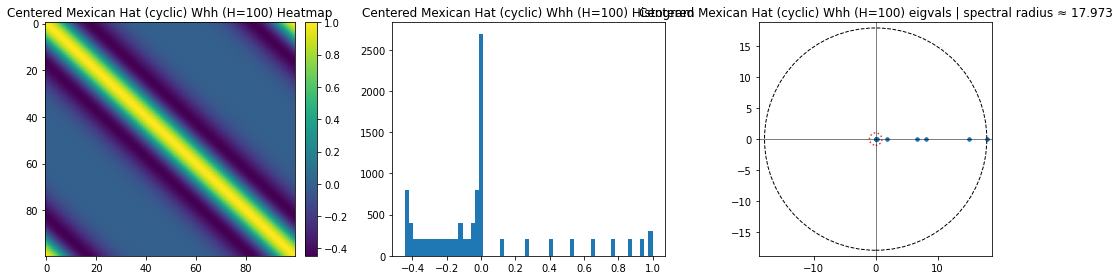

INITIAL SYMMETRY
NORMALIZATION COMPARISON
[builder] circulant? True (tol=1e-7)


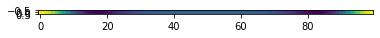

[ 1.00000000e+00  9.85062361e-01  9.40990746e-01  8.69957685e-01
  7.75417745e-01  6.61872685e-01  5.34572959e-01  3.99179310e-01
  2.61413664e-01  1.26725599e-01  0.00000000e+00 -1.14675626e-01
 -2.14170992e-01 -2.96394587e-01 -3.60298663e-01 -4.05815572e-01
 -4.33738202e-01 -4.45560098e-01 -4.43293095e-01 -4.29278344e-01
 -4.06005859e-01 -3.75954300e-01 -3.41459006e-01 -3.04612964e-01
 -2.67201483e-01 -2.30668902e-01 -1.96113333e-01 -1.64303675e-01
 -1.35713086e-01 -1.10563025e-01 -8.88719708e-02 -7.05047175e-02
 -5.52184507e-02 -4.27034386e-02 -3.26168351e-02 -2.46092752e-02
 -1.83443762e-02 -1.35118831e-02 -9.83542483e-03 -7.07594631e-03
 -5.03193960e-03 -3.53742111e-03 -2.45853281e-03 -1.68941880e-03
 -1.14789477e-03 -7.71256979e-04 -5.12454018e-04 -3.36739467e-04
 -2.18846268e-04 -1.40673204e-04 -8.94396726e-05 -1.40673204e-04
 -2.18846268e-04 -3.36739467e-04 -5.12454018e-04 -7.71256979e-04
 -1.14789477e-03 -1.68941880e-03 -2.45853281e-03 -3.53742111e-03
 -5.03193960e-03 -7.07594

In [9]:
# --- mexican hat (centered, cyclic) matrix ---
W = bhw.build_mexican_hat(n=HIDDEN_N, sigma=None, diag_offset=0, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Centered Mexican Hat (cyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
# hw.plot_sym_asym(W, base_title="Centered Mexican Hat (cyclic, raw)")

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)

print("NORMALIZATION COMPARISON")
# hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# verify circulant
ok = hw.is_circulant(W_fro, tol=1e-7)
print("[builder] circulant? {} (tol=1e-7)".format(ok))

# save variants
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/clean/mh-variants/cyc-centered"
)
# hw.save_matrix(
#    W_fro,
#    f"{save_root}",
#    f"cyccentmh",
#    meta={"norm": "fro", "hidden_n": HIDDEN_N},
# )

# extract first row
row0 = hw.extract_first_row(W)

# hw.extract_and_optionally_save_first_row(
#    W,
#    save_dir="../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/#centeredmh",
#    name="centeredmh_row0",
# )
plt.imshow(row0.reshape(1, 100))
plt.show()
print(row0)

In [10]:
# --- mexican hat (centered, acyclic) matrix ---
W = bhw.build_mexican_hat(n=HIDDEN_N, sigma=None, diag_offset=0, cyclic=False)

# quick plots
print("INITIAL MATRICES")
# hw.plot_weight_all(W, title=f"Centered Mexican Hat (acyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
# hw.plot_sym_asym(W, base_title="Centered Mexican Hat (acyclic, raw)")

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)

print("NORMALIZATION COMPARISON")
# hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# verify circulant
ok = hw.is_circulant(W_fro, tol=1e-7)
print("[builder] circulant? {} (tol=1e-7)".format(ok))

# save variants
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/clean/mh-variants/centered"
)
# hw.save_matrix(
#    W_fro, f"{save_root}", f"centmh", meta={"norm": "fro", "hidden_n": HIDDEN_N}
# )

INITIAL MATRICES
INITIAL SYMMETRY
NORMALIZATION COMPARISON
[builder] circulant? False (tol=1e-7)


In [11]:
# --- mexican hat (shifted, cyclic) matrix ---
W = bhw.build_mexican_hat(n=HIDDEN_N, sigma=None, diag_offset=-19, cyclic=True)

# quick plots
print("INITIAL MATRICES")
# hw.plot_weight_all(W, title=f"Shifted Mexican Hat (cyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
# hw.plot_sym_asym(W, base_title="Shifted Mexican Hat (cyclic, raw)")

# symmetric / skew-symmetric split
S = 0.5 * (W + W.T)
A = 0.5 * (W - W.T)

# choose mixing ratios you want
mix_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# where to save this structure's init
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/clean/mh-variants/cyc-shifted"
)

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

for alpha in mix_ratios:
    # alpha-blended hidden matrix: W_eff = αS + (1-α)A
    W_mix = alpha * S + (1 - alpha) * A

    # (optional) quick diagnostics
    print(f"λ = {alpha:.2f}")
    # hw.plot_sym_asym(W_mix, base_title=f"Shifted MH (cyclic) α={alpha:.2f}")
    # hw.plot_weight_all(W_mix, title=f"Whh (α={alpha:.2f}, raw)")

    # apply your three normalizations per alpha (and keep a raw copy)
    W_fro, _ = hw.normalize_by_fro(W_mix, target_fro=target_fro)

    # save under norm subfolders, with a alpha subdir (easy to browse)
    meta_base = {
        "structure": "Shifted MH (cyclic)",
        "hidden_n": int(HIDDEN_N),
        "lambda": float(alpha),
        "decomposition": "W=αS+(1-α)A",
        "notes": "normalized after α-mix",
    }
    sub = mix_ratio_tag(alpha)

    # verify circulant
    ok = hw.is_circulant(W_fro, tol=1e-7)
    print("[builder] circulant? {} (tol=1e-7)".format(ok))

    # frobenius
    # hw.save_matrix(
    #    W_fro,
    #    f"{save_root}/{sub}",
    #    f"cycshiftmh_{sub}",
    #    meta={**meta_base, "norm": "frobenius", "target_fro": float#(target_fro)},
    # )

    # extract first row
    row0 = hw.extract_first_row(W_mix)

    hw.extract_and_optionally_save_first_row(
        W_mix,
        save_dir=f"../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/shiftedmh/{sub}",
        name=f"shiftedmh_{sub}_row0",
    )

INITIAL MATRICES
INITIAL SYMMETRY
λ = 0.00
[builder] circulant? True (tol=1e-7)
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/shiftedmh/sym0p00/shiftedmh_sym0p00_row0.npy and ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/shiftedmh/sym0p00/shiftedmh_sym0p00_row0.json
λ = 0.25
[builder] circulant? True (tol=1e-7)
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/shiftedmh/sym0p25/shiftedmh_sym0p25_row0.npy and ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/shiftedmh/sym0p25/shiftedmh_sym0p25_row0.json
λ = 0.50
[builder] circulant? True (tol=1e-7)
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/shiftedmh/sym0p50/shiftedmh_sym0p50_row0.npy and ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/shiftedmh/sym0p50/shiftedmh_sym0p50_row0.json
λ = 0.75
[builder] circulant? True (tol=1e-7)
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/circulant/shiftedmh/sym0p75/shiftedmh_sym0p75_row0.n

In [12]:
# --- mexican hat (shifted, acyclic) matrix ---
W = bhw.build_mexican_hat(n=HIDDEN_N, sigma=None, diag_offset=-19, cyclic=False)

# quick plots
print("INITIAL MATRICES")
# hw.plot_weight_all(W, title=f"Shifted Mexican Hat (acyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
# hw.plot_sym_asym(W, base_title="Shifted Mexican Hat (acyclic, raw)")

# symmetric / skew-symmetric split
S = 0.5 * (W + W.T)
A = 0.5 * (W - W.T)

# choose mixing ratios you want
mix_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# where to save this structure's init
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/clean/mh-variants/shifted"
)

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5

for alpha in mix_ratios:
    # alpha-blended hidden matrix: W_eff = αS + (1-α)A
    W_mix = alpha * S + (1 - alpha) * A

    # (optional) quick diagnostics
    print(f"λ = {alpha:.2f}")
    # hw.plot_sym_asym(W_mix, base_title=f"Shifted MH (acyclic) α={alpha:.2f}")
    # hw.plot_weight_all(W_mix, title=f"Whh (α={alpha:.2f}, raw)")

    # apply your three normalizations per alpha (and keep a raw copy)
    W_raw = W_mix
    W_fro, _ = hw.normalize_by_fro(W_mix, target_fro=target_fro)

    # save under norm subfolders, with a alpha subdir (easy to browse)
    meta_base = {
        "structure": "Shifted MH (acyclic)",
        "hidden_n": int(HIDDEN_N),
        "lambda": float(alpha),
        "decomposition": "W=αS+(1-α)A",
        "notes": "normalized after α-mix",
    }
    sub = mix_ratio_tag(alpha)

    # verify circulant
    ok = hw.is_circulant(W_fro, tol=1e-7)
    print("[builder] circulant? {} (tol=1e-7)".format(ok))

    # frobenius
    # hw.save_matrix(
    #    W_fro,
    #    f"{save_root}/{sub}",
    #    f"shiftmh_{sub}",
    #    meta={**meta_base, "norm": "frobenius", "target_fro": float#(target_fro)},
    # )

INITIAL MATRICES
INITIAL SYMMETRY
λ = 0.00
[builder] circulant? False (tol=1e-7)
λ = 0.25
[builder] circulant? False (tol=1e-7)
λ = 0.50
[builder] circulant? False (tol=1e-7)
λ = 0.75
[builder] circulant? False (tol=1e-7)
λ = 1.00
[builder] circulant? False (tol=1e-7)


# Tridiagonal

In [13]:
# --- tridiagonal (centered, cyclic) matrix ---
W = bhw.build_tridiag(n=HIDDEN_N, diag=1, off=-1, diag_offset=0, cyclic=True)

# quick plots
print("INITIAL MATRICES")
# hw.plot_weight_all(W, title=f"Centered Tridiagonal (cyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
# hw.plot_sym_asym(W, base_title="Centered Tridiagonal (cyclic, raw)")

# normalization comparisons
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)

print("NORMALIZATION COMPARISON")
# hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/centcyctridiag"
"""
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"centcyctridiag_n{hidden_n}_fro",
    meta={"norm": "fro"},
)
"""

INITIAL MATRICES
INITIAL SYMMETRY
NORMALIZATION COMPARISON


'\nhw.save_matrix(\n    W_fro,\n    f"{save_root}/frobenius",\n    f"centcyctridiag_n{hidden_n}_fro",\n    meta={"norm": "fro"},\n)\n'

INITIAL MATRICES


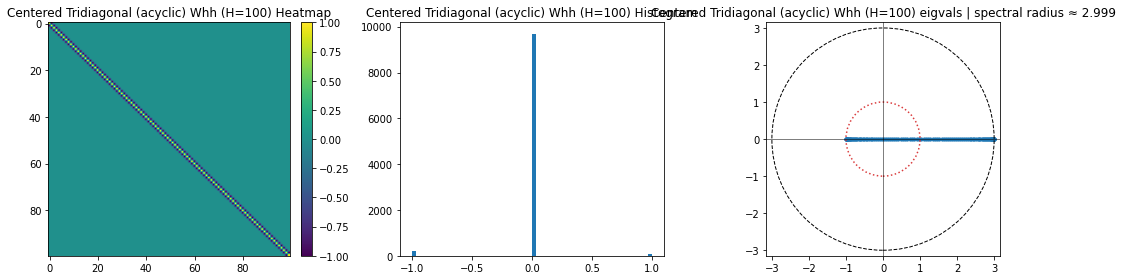

INITIAL SYMMETRY
[Centered Tridiagonal (acyclic, raw) — symmetric] var=0.029704  σ_max=2.9990  ρ=2.9990  asym=0.0000  mean=-9.800e-03
[Centered Tridiagonal (acyclic, raw) — skew] var=0  σ_max=0.0000  ρ=0.0000  asym=0.0000  mean=0.000e+00


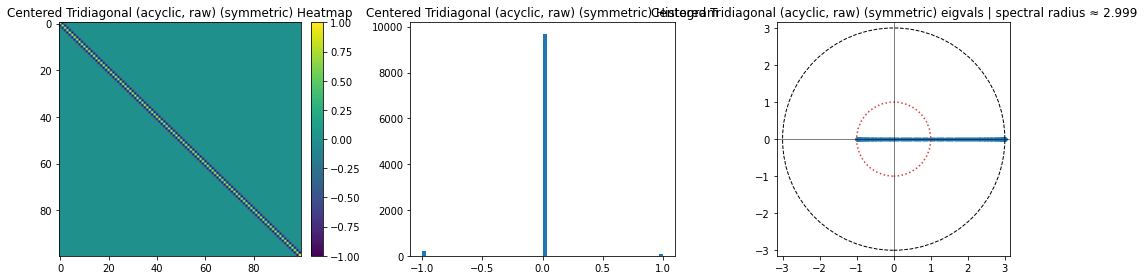

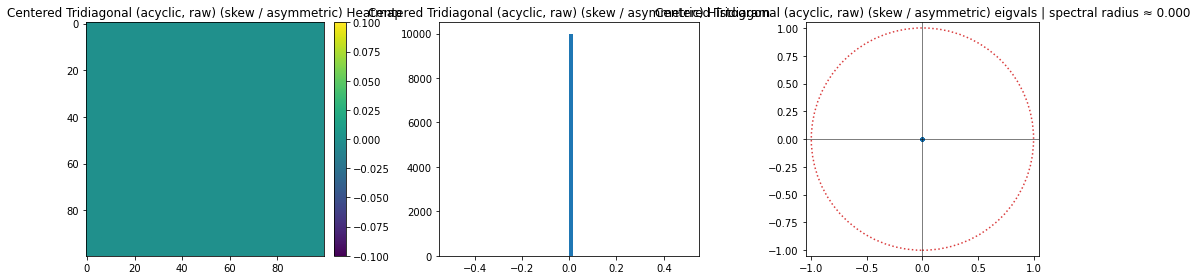

NORMALIZATION


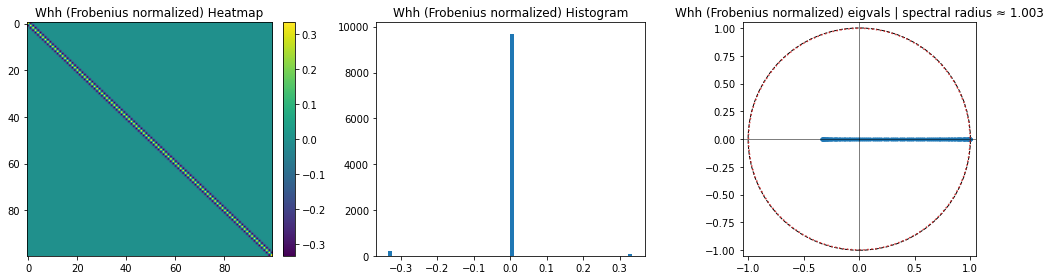

'\nhw.save_matrix(\n    W_fro,\n    f"{save_root}/frobenius",\n    f"centtridiag_n{HIDDEN_N}_fro",\n    meta={"norm": "fro"},\n)\n'

In [14]:
# --- tridiagonal (centered, acyclic) matrix ---
W = bhw.build_tridiag(n=HIDDEN_N, diag=1, off=-1, diag_offset=0, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Centered Tridiagonal (acyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Centered Tridiagonal (acyclic, raw)")

# normalization
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)

print("NORMALIZATION")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/centtridiag"
"""
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"centtridiag_n{HIDDEN_N}_fro",
    meta={"norm": "fro"},
)
"""

INITIAL MATRICES


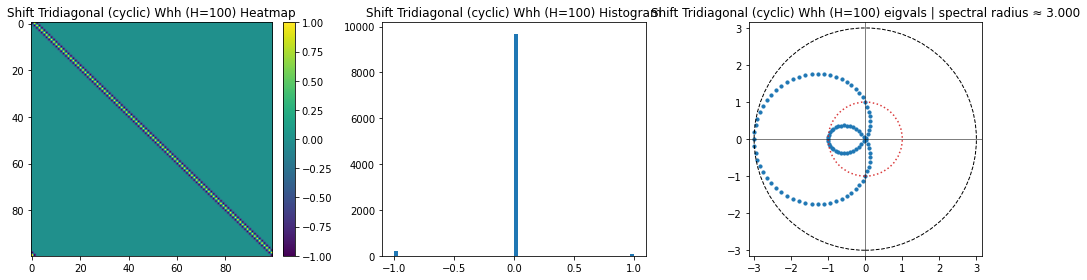

INITIAL SYMMETRY
[Shift Tridiagonal (cyclic, raw) — symmetric] var=0.0199  σ_max=3.0000  ρ=3.0000  asym=0.0000  mean=-1.000e-02
[Shift Tridiagonal (cyclic, raw) — skew] var=0.01  σ_max=1.7601  ρ=1.7601  asym=2.0000  mean=0.000e+00


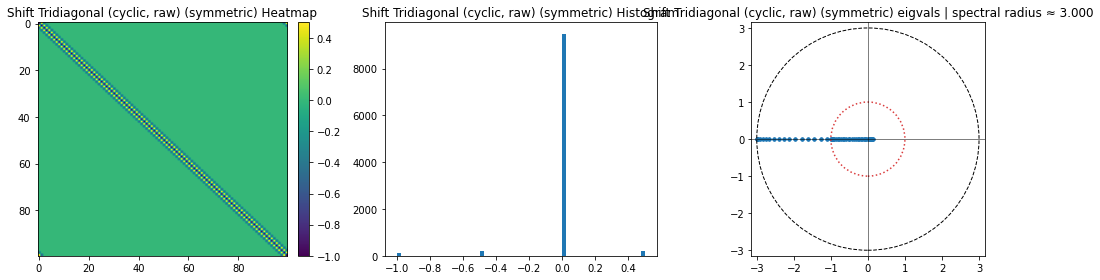

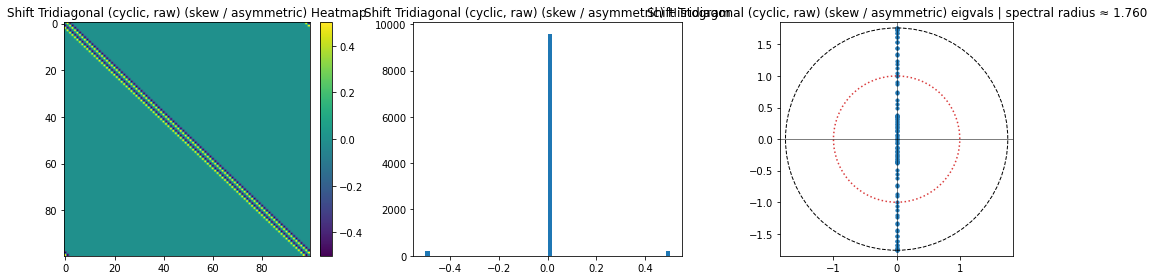

NORMALIZATION


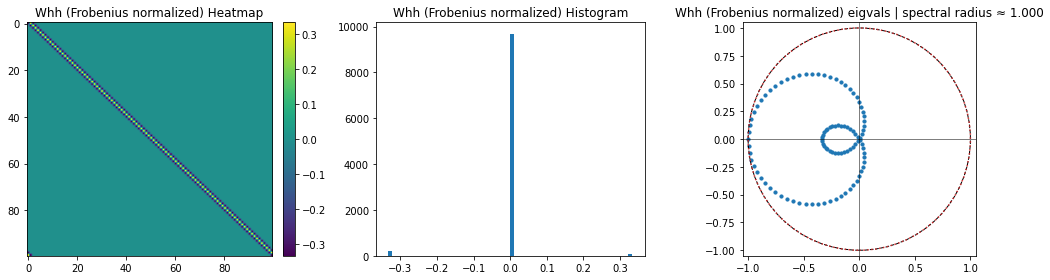

'\nhw.save_matrix(\n    W_fro,\n    f"{save_root}/frobenius",\n    f"shiftcyctridiag_n{HIDDEN_N}_fro",\n    meta={"norm": "fro"},\n)\n'

In [15]:
# --- tridiagonal (shift, cyclic) matrix ---
W = bhw.build_tridiag(n=HIDDEN_N, diag=1, off=-1, diag_offset=1, cyclic=True)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shift Tridiagonal (cyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shift Tridiagonal (cyclic, raw)")

# normalization
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/shiftcyctridiag"
"""
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"shiftcyctridiag_n{HIDDEN_N}_fro",
    meta={"norm": "fro"},
)
"""

INITIAL MATRICES


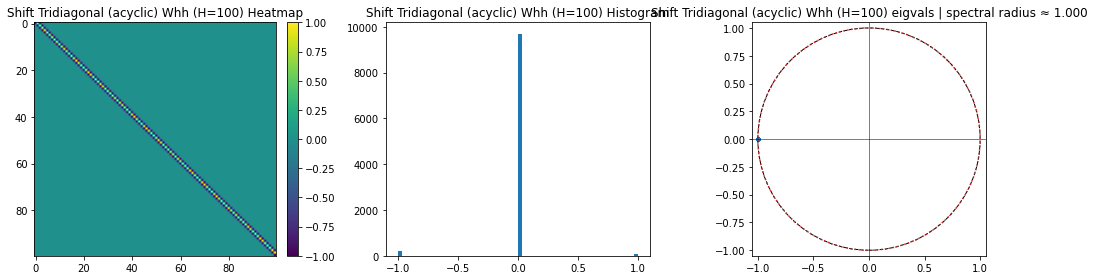

INITIAL SYMMETRY
[Shift Tridiagonal (acyclic, raw) — symmetric] var=0.019752  σ_max=2.9976  ρ=2.9976  asym=0.0000  mean=-9.900e-03
[Shift Tridiagonal (acyclic, raw) — skew] var=0.00985  σ_max=1.7580  ρ=1.7580  asym=2.0000  mean=0.000e+00


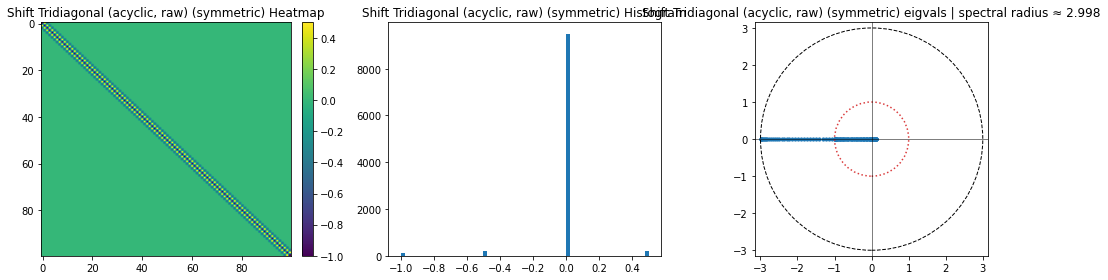

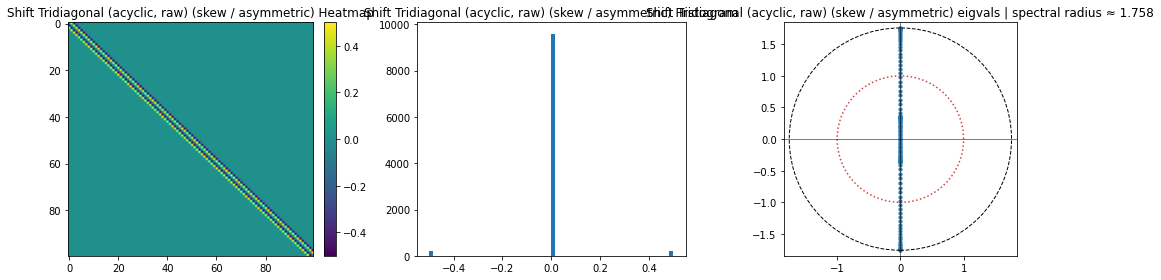

NORMALIZATION COMPARISON


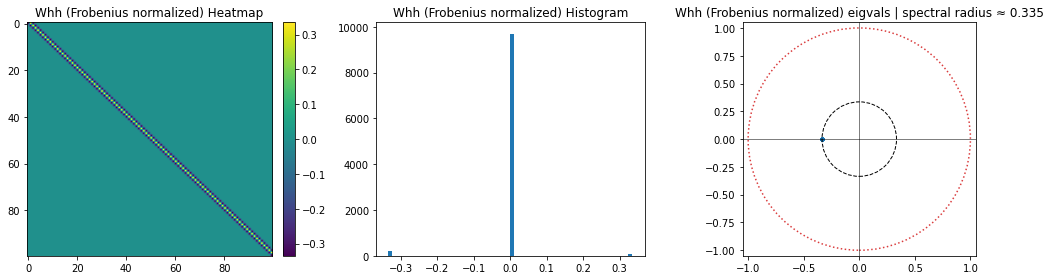

'\nhw.save_matrix(\n    W_fro,\n    f"{save_root}/frobenius",\n    f"shifttridiag_n{hidden_n}_fro",\n    meta={"norm": "fro"},\n)\n'

In [16]:
# --- tridiagonal (shift, acyclic) matrix ---
W = bhw.build_tridiag(n=HIDDEN_N, diag=1, off=-1, diag_offset=1, cyclic=False)

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Shift Tridiagonal (acyclic) Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Shift Tridiagonal (acyclic, raw)")

# normalization
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/shifttridiag"
"""
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"shifttridiag_n{hidden_n}_fro",
    meta={"norm": "fro"},
)
"""

# Unsorted Pretrained

In [17]:
# load PyTorch checkpoint from random init
import torch

path = "../runs/ElmanRNN/random-init/random_n100/run_04/random_n100.pth.tar"
ckpt = torch.load(path)

W = ckpt["weights"]["W_hh_history"][-1].astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/random_n100"
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"random_n{HIDDEN_N}_fro_learned",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"random_n{HIDDEN_N}_learned",
    meta={"norm": "raw"},
)

FileNotFoundError: [Errno 2] No such file or directory: '../runs/ElmanRNN/random-init/random_n100/run_04/random_n100.pth.tar'

INITIAL MATRICES


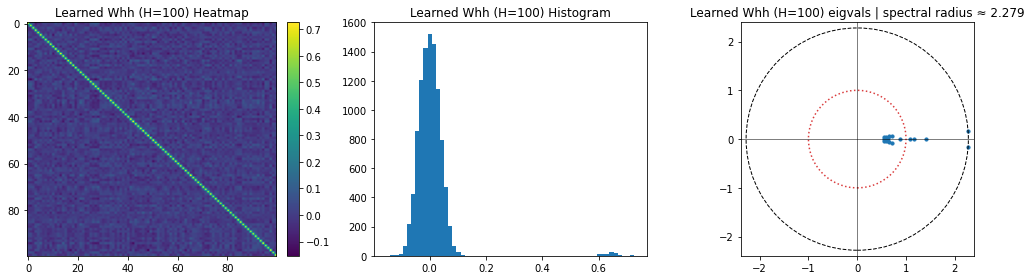

INITIAL SYMMETRY
[Learned (unsorted) — symmetric] var=0.00501653  σ_max=2.6088  ρ=2.6088  asym=0.0000  mean=6.531e-03
[Learned (unsorted) — skew] var=0.00030243  σ_max=0.8492  ρ=0.8492  asym=2.0000  mean=0.000e+00


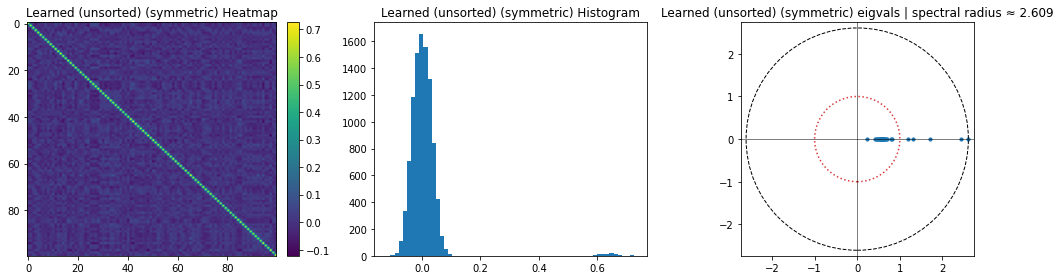

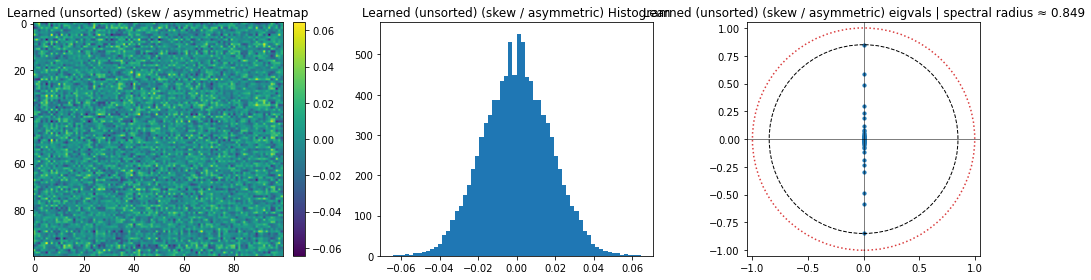

NORMALIZATION COMPARISON


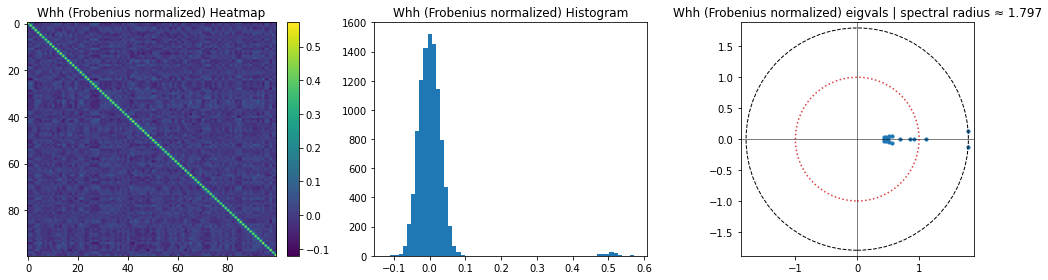

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/identity_n100/frobenius/identity_n100_fro_learned.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/identity_n100/raw/identity_n100_learned.npy and .json


In [ ]:
# load PyTorch checkpoint from random init
import torch

path = "../runs/ElmanRNN/shift-variants/identity/frobenius/identity_n100_fro/run_00/identity_n100_fro.pth.tar"
ckpt = torch.load(path)

W = ckpt["weights"]["W_hh_history"][-1].astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/identity_n100"
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"identity_n{HIDDEN_N}_fro_learned",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"identity_n{HIDDEN_N}_learned",
    meta={"norm": "raw"},
)

In [ ]:
# load PyTorch checkpoint from random init
import torch

path = "../runs/ElmanRNN/shift-variants/identity/frobenius/identity_n100_fro/run_00/identity_n100_fro.pth.tar"
ckpt = torch.load(path)

W = ckpt["weights"]["W_hh_history"][-1].astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/identity_n100"
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"identity_n{HIDDEN_N}_fro_learned",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"identity_n{HIDDEN_N}_learned",
    meta={"norm": "raw"},
)

INITIAL MATRICES


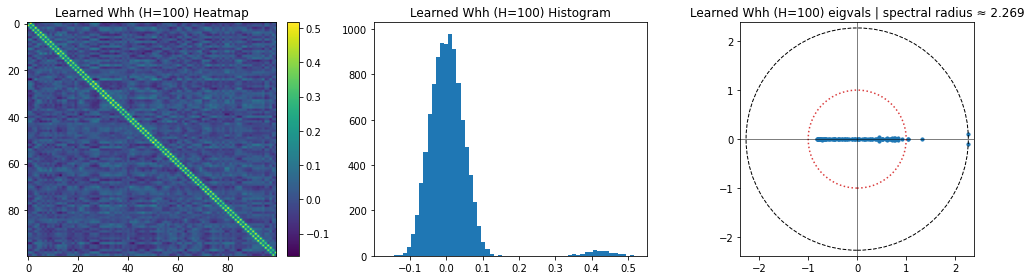

INITIAL SYMMETRY
[Learned (unsorted) — symmetric] var=0.00481382  σ_max=2.7554  ρ=2.7554  asym=0.0000  mean=9.782e-03
[Learned (unsorted) — skew] var=0.000465361  σ_max=1.0863  ρ=1.0863  asym=2.0000  mean=0.000e+00


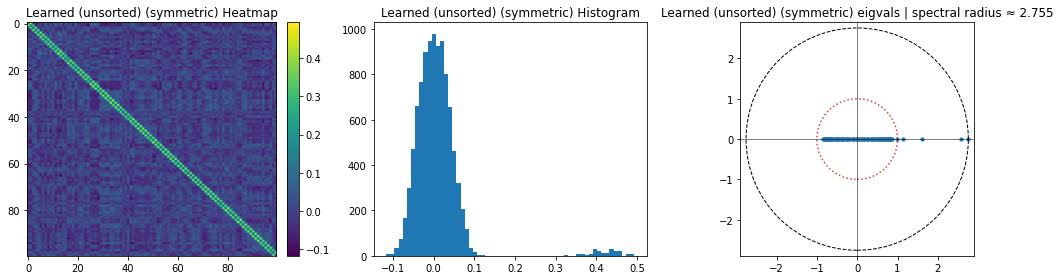

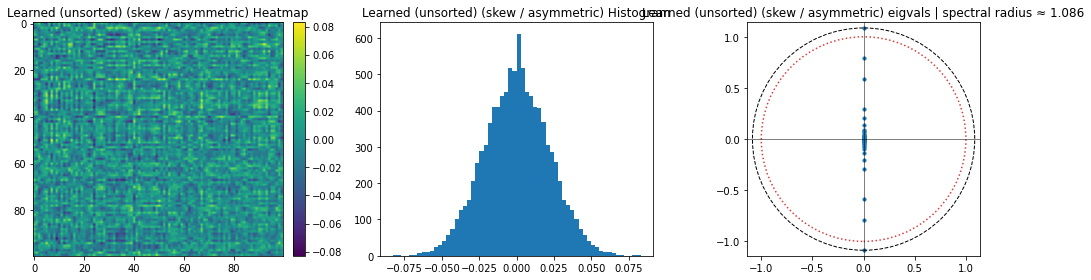

NORMALIZATION COMPARISON


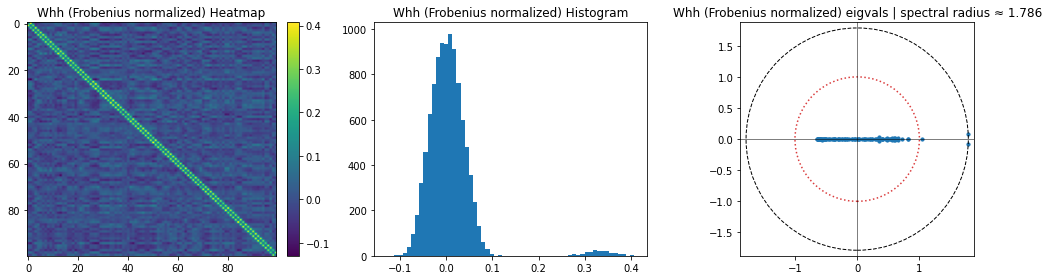

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shift_n100_fro_sym1p00/frobenius/shift_n100_fro_sym1p00_learned.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shift_n100_fro_sym1p00/raw/shift_n100_sym1p00_learned.npy and .json


In [ ]:
# load PyTorch checkpoint from random init
import torch

path = "../runs/ElmanRNN/shift-variants/shift/frobenius/sym1p00/shift_n100_fro_sym1p00/run_00/shift_n100_fro_sym1p00.pth.tar"
ckpt = torch.load(path)

W = ckpt["weights"]["W_hh_history"][-1].astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shift_n100_fro_sym1p00"
)
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"shift_n{HIDDEN_N}_fro_sym1p00_learned",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"shift_n{HIDDEN_N}_sym1p00_learned",
    meta={"norm": "raw"},
)

INITIAL MATRICES


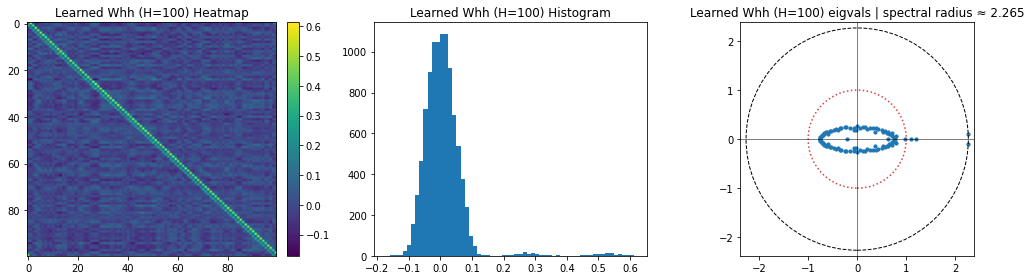

INITIAL SYMMETRY
[Learned (unsorted) — symmetric] var=0.00448284  σ_max=2.7666  ρ=2.7666  asym=0.0000  mean=9.511e-03
[Learned (unsorted) — skew] var=0.000775911  σ_max=1.0986  ρ=1.0986  asym=2.0000  mean=2.384e-11


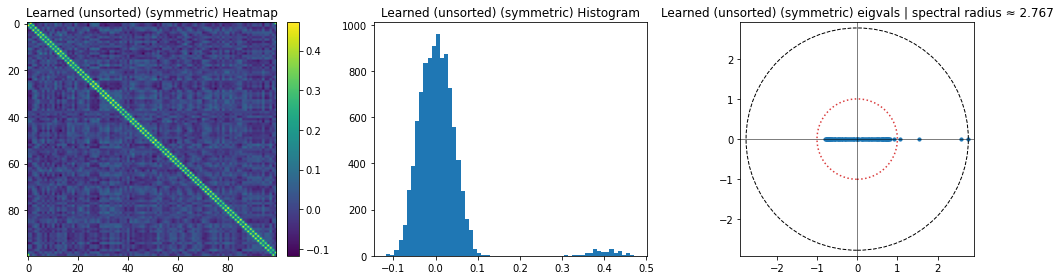

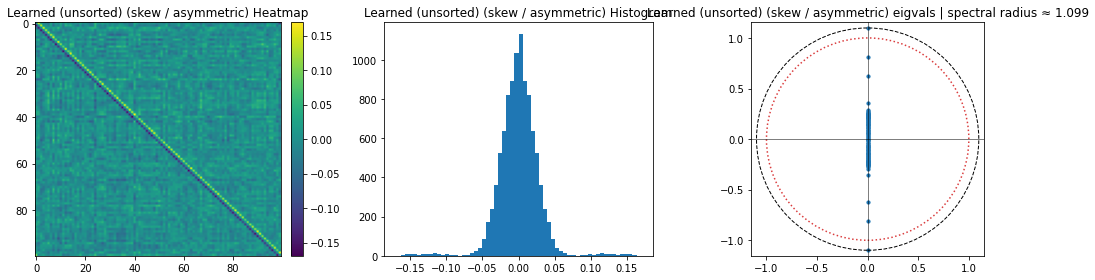

NORMALIZATION COMPARISON


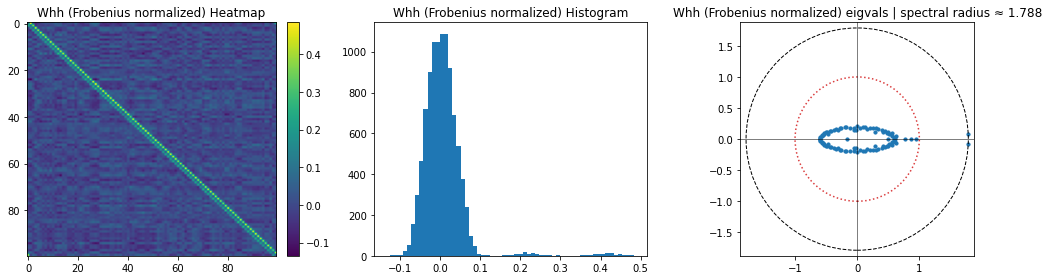

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shiftcyc_n100_fro_sym0p75/frobenius/shiftcyc_n100_fro_sym0p75_learned.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shiftcyc_n100_fro_sym0p75/raw/shiftcyc_n100_sym0p75_learned.npy and .json


In [ ]:
# load PyTorch checkpoint from random init
import torch

path = "../runs/ElmanRNN/shift-variants/shift-cyc/frobenius/sym0p75/shiftcyc_n100_fro_sym0p75/run_00/shiftcyc_n100_fro_sym0p75.pth.tar"
ckpt = torch.load(path)

W = ckpt["weights"]["W_hh_history"][-1].astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/shiftcyc_n100_fro_sym0p75"
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"shiftcyc_n{HIDDEN_N}_fro_sym0p75_learned",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"shiftcyc_n{HIDDEN_N}_sym0p75_learned",
    meta={"norm": "raw"},
)

# Sorted Pretrained

In [ ]:
import numpy as np

INITIAL MATRICES


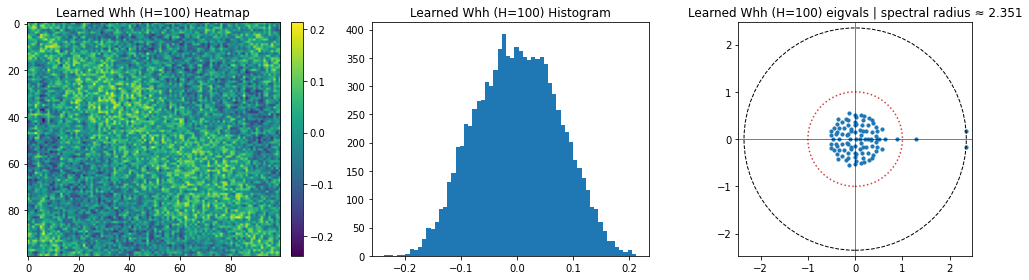

INITIAL SYMMETRY
[Learned (unsorted) — symmetric] var=0.00344412  σ_max=2.7836  ρ=2.7836  asym=0.0000  mean=5.806e-04
[Learned (unsorted) — skew] var=0.00201725  σ_max=1.1746  ρ=1.1746  asym=2.0000  mean=-2.384e-11


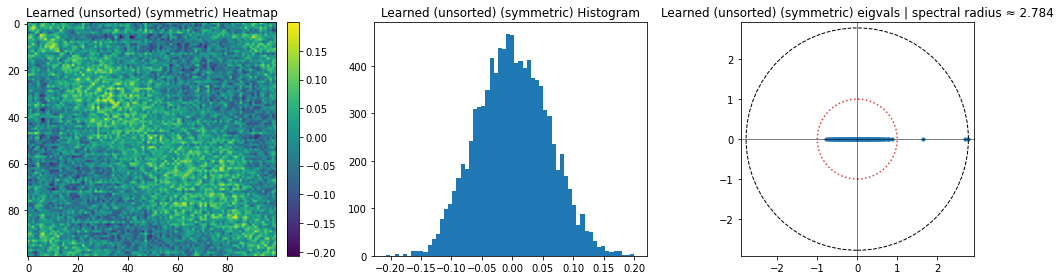

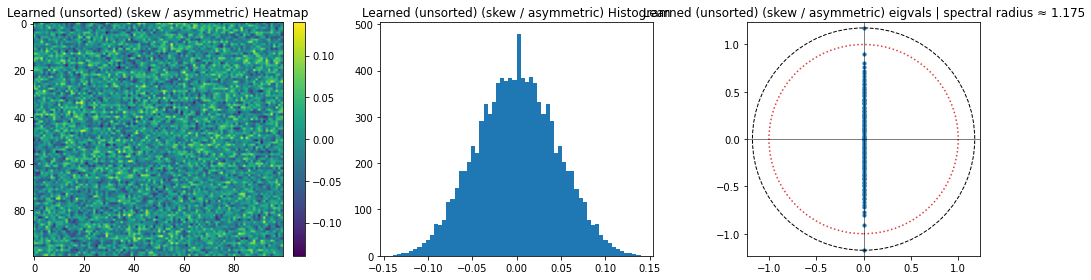

NORMALIZATION COMPARISON


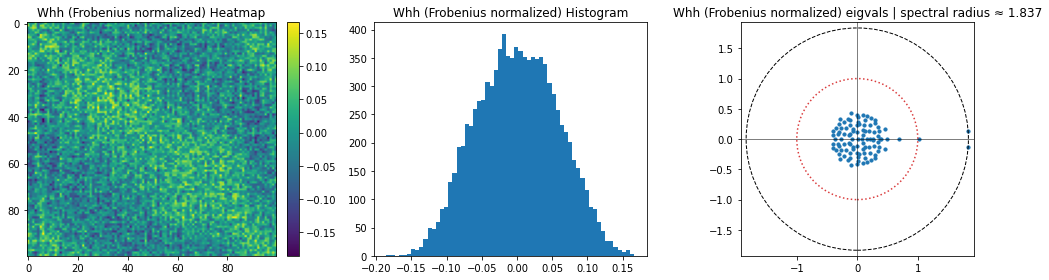

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/sorted/random_n100/frobenius/random_n100_fro_learned_sorted.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/sorted/random_n100/raw/random_n100_learned_sorted.npy and .json


In [ ]:
path = "../runs/ElmanRNN/random-init/random_n100/run_04/analysis/weights/Wsorted_epoch099000.npy"

W = np.load(path).astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")


# save variants
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/sorted/random_n100"
)
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"random_n{HIDDEN_N}_fro_learned_sorted",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"random_n{HIDDEN_N}_learned_sorted",
    meta={"norm": "raw"},
)

INITIAL MATRICES


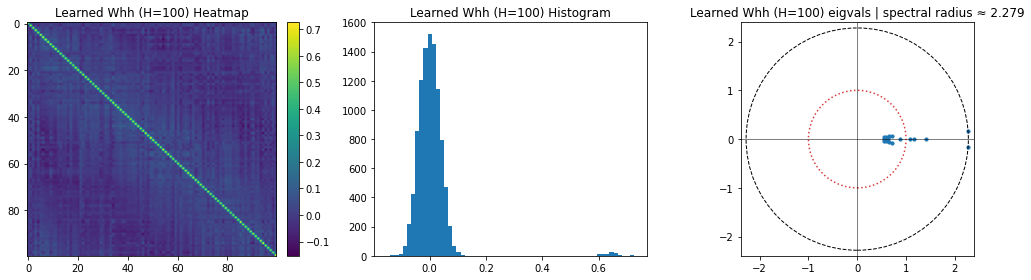

INITIAL SYMMETRY
[Learned (unsorted) — symmetric] var=0.00501653  σ_max=2.6088  ρ=2.6088  asym=0.0000  mean=6.531e-03
[Learned (unsorted) — skew] var=0.00030243  σ_max=0.8492  ρ=0.8492  asym=2.0000  mean=0.000e+00


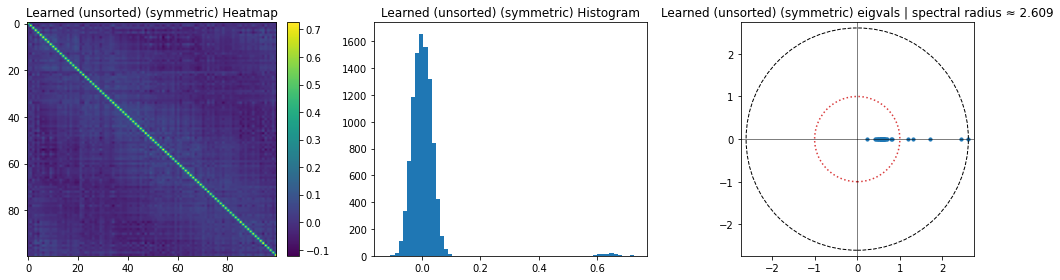

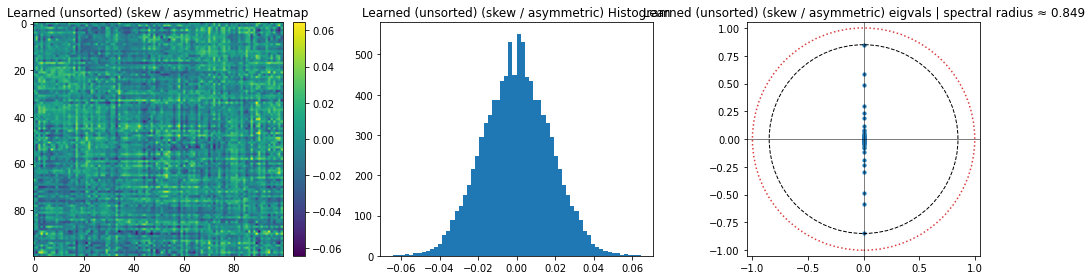

NORMALIZATION COMPARISON


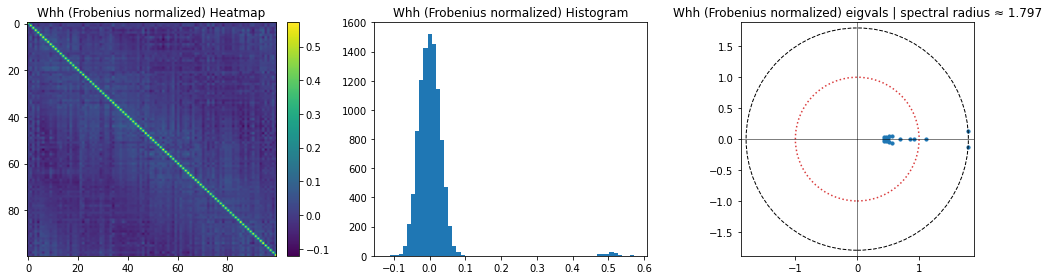

Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/sorted/identity_n100/frobenius/identity_n100_fro_learned_sorted.npy and .json
Saved: ../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/sorted/identity_n100/raw/identity_n100_learned_sorted.npy and .json


In [ ]:
path = "../runs/ElmanRNN/shift-variants/identity/frobenius/identity_n100_fro/run_00/analysis/weights/Wsorted_epoch099000.npy"

W = np.load(path).astype(np.float32)
HIDDEN_N = W.shape[0]

# quick plots
print("INITIAL MATRICES")
hw.plot_weight_all(W, title=f"Learned Whh (H={HIDDEN_N})")

# symmetry
print("INITIAL SYMMETRY")
hw.plot_sym_asym(W, base_title="Learned (unsorted)")

# normalization comparisons
THEO_VAR = 1.0 / (3.0 * HIDDEN_N)
target_fro = (W.size * THEO_VAR) ** 0.5
W_fro, _ = hw.normalize_by_fro(W, target_fro=target_fro)
print("NORMALIZATION COMPARISON")
hw.plot_weight_all(W_fro, title="Whh (Frobenius normalized)")

# save variants
save_root = (
    "../data/Ns100_SeqN100/hidden-weight-inits/ElmanRNN/learned/sorted/identity_n100"
)
hw.save_matrix(
    W_fro,
    f"{save_root}/frobenius",
    f"identity_n{HIDDEN_N}_fro_learned_sorted",
    meta={"norm": "fro"},
)
hw.save_matrix(
    W,
    f"{save_root}/raw",
    f"identity_n{HIDDEN_N}_learned_sorted",
    meta={"norm": "raw"},
)